# Sentiment Analysis for Trump Speeches

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import string

from collections import Counter
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import TransformerMixin
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)
c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Pool size changed, may indicate binary incompatibility. Expected 48 from C header, got 64 from PyObject
  return f(*args, **kwds)
c:\users\cmiller\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: cymem.cymem.Address size changed, may indicate binary incompatibility. Expected 24 from C header, got 40 from PyObject
  return f(*args, **kwds)


In [2]:
path = 'C:/Users/Cmiller/Downloads/MrTrumpSpeeches.csv.zip'
data = pd.read_csv(path, delimiter='~', engine='python', compression='zip')
#print(data.head())
print(data.shape)

(836, 9)


## Need to create a categorical target variable

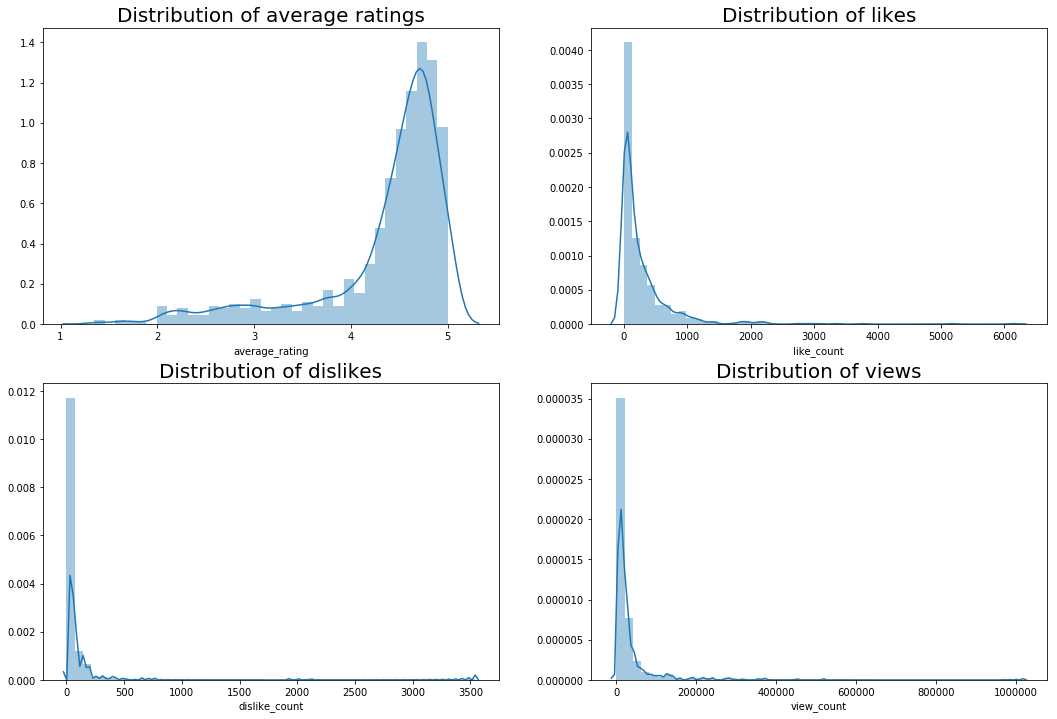

In [3]:
# check out distribution of average rating, likes, dislikes, and view count
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(18,12))

sns.distplot(data.average_rating,ax=ax1)
ax1.set_title('Distribution of average ratings', fontsize=20)

sns.distplot(data.like_count, ax=ax2)
ax2.set_title('Distribution of likes', fontsize=20)

sns.distplot(data.dislike_count, ax=ax3)
ax3.set_title('Distribution of dislikes', fontsize=20)

sns.distplot(data.view_count, ax=ax4)
ax4.set_title('Distribution of views', fontsize=20)
plt.show()


Definitely seems to have more likes than dislikes in the dataset.

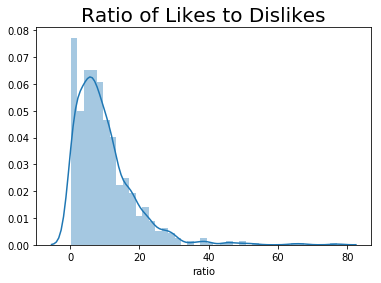

count    836.000000
mean       9.849951
std        8.732936
min        0.136364
25%        4.017442
50%        7.972603
75%       13.000000
max       77.000000
Name: ratio, dtype: float64


In [4]:
#create ratio of likes to dislikes
data['ratio'] = (data.like_count+1)/(data.dislike_count+1)

sns.distplot(data.ratio)
plt.title('Ratio of Likes to Dislikes', fontsize=20)
plt.show()

print(data.ratio.describe())

In [5]:
print('If we classify average rating of 4 or greater as good, ' 
      'we would have {} goods and {} bads'.format(data[data.average_rating >= 4].shape[0],
                                                  data.shape[0]-data[data.average_rating>=4].shape[0]))
print('')
print('Classifying a ratio of 8 or greater as good'
      'we get {} goods and {} bads'.format(data[data.ratio>=8].shape[0], data.shape[0]-data[data.ratio>=8].shape[0]))


If we classify average rating of 4 or greater as good, we would have 682 goods and 154 bads

Classifying a ratio of 8 or greater as goodwe get 418 goods and 418 bads


Initially, let's choose the target variable as the ratio greater than 8 to have a more balanced dataset.

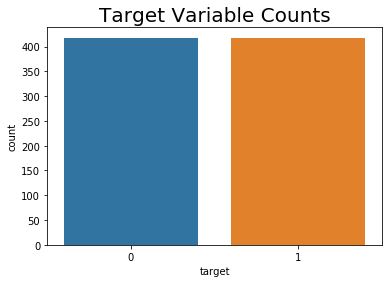

In [6]:
data['target'] = np.where(data.ratio >= 8, 1, 0)
sns.countplot(data.target)
plt.title('Target Variable Counts', fontsize=20)
plt.show()

## Check out the text in the dataset

In [7]:
from functools import reduce
line_chars = list(data.subtitles.apply(lambda x: len(x)))
tot_chars = reduce(lambda x,y: x+y, line_chars)
print('The total number of text characters is {:,}'.format(tot_chars))

The total number of text characters is 13,475,306


In [8]:
pd.options.display.max_colwidth=-1
#print(data.subtitles.head())

We need to remove the [Music] and [Applause] from the subtitles.

## Load into Spacy

In [9]:
# load in english from spacy
nlp = spacy.load('en')

# build a list of stop words
stop_words = set(list(stopwords.words('english')) + list(ENGLISH_STOP_WORDS) + list(STOP_WORDS))

# get punctuation from string module
punct = list(string.punctuation) + ['--','---','...']

############################################## SpaCy tokenizer ##############################################

def tokenizeText(text):
    '''Create a function that will return lemmas and remove punctuation and stop words'''
    
    # get the full nlp data
    tokens = nlp(text)
    
    # get lemmas for words in data and leave pronouns as is
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != '-PRON-' else tok.lower_ for tok in tokens]
    
    # remove stop words, punctuation, and numbers
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punct]
 
    return tokens

############################################## Custom transformer class ##############################################

# since all steps in the pipeline must be a transformer -create custom transformer 
class CleanTextTransformer(TransformerMixin):
    """Convert text to cleaned text"""
    # Fits data together
    def fit(self, X, y=None, **fit_params):
        return self
    
    # Transforms data by removing [] and words inside
    def transform(self, X, **transformer_params):
        return [text_cleaner(text) for text in X]

    # Returns dictionary of parameters
    def get_params(self, deep=True):
        return {}

############################################## Text Cleaner ##############################################
    
def text_cleaner(text):
    # remove [] and words inside
    alltext = re.sub("[\[].*?[\]]", "", text)
    
    # Remove numbers
    alltext = alltext.translate(str.maketrans('','', string.digits))
    
    # split each word and make lowercase and rejoin with one space to remove large gaps
    alltext = ' '.join(alltext.lower().split())
    
    return alltext

In [10]:
# Count Vectorizer
cvect = CountVectorizer(tokenizer=tokenizeText, # use spacy tokenizer
                        strip_accents='unicode', # strip accents using more robust search
                        max_df=0.5, # drop words that occur in over half of the speeches
                        min_df=2, # include words that occur at least twice
                        ngram_range=(1,2), # include bigrams because Trump likes his adjectives
                        max_features=2500 # keep only the top 2500 features
                       )

# Tf-Idf Vectorizer
tfidfvect = TfidfVectorizer(tokenizer=tokenizeText, # use spacy tokenizer
                        strip_accents='unicode', # strip accents using more robust search
                        max_df=0.5, # drop words that occur in over half of the speeches
                        min_df=2, # include words that occur at least twice
                        ngram_range=(1,2), # include bigrams because Trump likes his adjectives
                        max_features=2500, # keep only the top 2500 features
                        smooth_idf=True, # smoothing, add 1 to prevent divide by 0
                        norm='l2', # most common norm - Euclidean norm 
                       )

In [11]:
# make a pipeline to vectorize dataset
log_reg = LogisticRegression()
svc = SVC(kernel='linear')
rfc = RandomForestClassifier()
bnb = BernoulliNB()

pipelr = Pipeline([('clean', CleanTextTransformer()),('vec', cvect), ('clf', log_reg)])
pipesvc = Pipeline([('clean', CleanTextTransformer()), ('vec', cvect), ('clf', svc)])
piperfc = Pipeline([('clean', CleanTextTransformer()), ('vec', cvect), ('clf', rfc)])
pipebnb = Pipeline([('clean', CleanTextTransformer()), ('vec', cvect), ('clf', bnb)])

In [12]:
# split data in train and test
X = data.subtitles
y = data.target

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Support Vector Machine pipeline
pipesvc.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('clean', <__main__.CleanTextTransformer object at 0x000001734A89D5C0>), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2500, min_df=2,
     ...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [14]:
# Score the SVC
pred = pipesvc.predict(xtest)
print(metrics.classification_report(ytest, pred))
print(metrics.accuracy_score(ytest, pred))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62        82
           1       0.64      0.65      0.64        86

   micro avg       0.63      0.63      0.63       168
   macro avg       0.63      0.63      0.63       168
weighted avg       0.63      0.63      0.63       168

0.6309523809523809


In [15]:
# Fit log reg
pipelr.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('clean', <__main__.CleanTextTransformer object at 0x000001734A89D518>), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2500, min_df=2,
     ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [16]:
# Score the Log Regression
pred = pipelr.predict(xtest)
print(metrics.classification_report(ytest, pred))
print(metrics.accuracy_score(ytest, pred))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62        82
           1       0.65      0.70      0.67        86

   micro avg       0.65      0.65      0.65       168
   macro avg       0.65      0.65      0.65       168
weighted avg       0.65      0.65      0.65       168

0.6488095238095238


In [17]:
# Fit random forest
piperfc.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('clean', <__main__.CleanTextTransformer object at 0x000001734A864A90>), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2500, min_df=2,
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [18]:
# Score the Random Forest
pred = piperfc.predict(xtest)
print(metrics.classification_report(ytest, pred))
print(metrics.accuracy_score(ytest, pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72        82
           1       0.73      0.71      0.72        86

   micro avg       0.72      0.72      0.72       168
   macro avg       0.72      0.72      0.72       168
weighted avg       0.72      0.72      0.72       168

0.7202380952380952


In [19]:
# Fit Bernoulli NB
pipebnb.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('clean', <__main__.CleanTextTransformer object at 0x000001734A89D710>), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=2500, min_df=2,
     ... vocabulary=None)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [20]:
# Score the Bernoulli NB
pred = pipebnb.predict(xtest)
print(metrics.classification_report(ytest, pred))
print(metrics.accuracy_score(ytest, pred))

              precision    recall  f1-score   support

           0       0.64      0.77      0.70        82
           1       0.72      0.58      0.65        86

   micro avg       0.67      0.67      0.67       168
   macro avg       0.68      0.67      0.67       168
weighted avg       0.68      0.67      0.67       168

0.6726190476190477


In [21]:
# Score the Random Forest again with a cross validation on the training set
scorer = metrics.make_scorer(metrics.accuracy_score)
rfc_cross_val = cross_val_score(estimator=piperfc, X=xtrain, y=ytrain, scoring=scorer, cv=5)

In [22]:
print(rfc_cross_val)

[0.74074074 0.76865672 0.65413534 0.71428571 0.69172932]


# Build Bag of Words without Pipeline

In [23]:
# Clean the text for parsing
data['subtitles_cleaned'] = data.subtitles.apply(text_cleaner)

# Parse the data vectorize it at the same time - using the spacy tokenizer we created before
cvect.fit(data.subtitles_cleaned)
X1 = cvect.transform(data.subtitles_cleaned)


In [24]:
cv_df = pd.DataFrame(X1.todense(), columns=cvect.get_feature_names())
#print(cv_df.head())

In [25]:
# try the random forest on this it should be the same...
x1train, x1test, y1train, y1test = train_test_split(X1, y, test_size=0.2, random_state=42)
rfc.fit(x1train, y1train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
rfc.score(x1test, y1test)

0.7261904761904762

In [27]:
# create new features
def new_features(text):
    
    #tokenize text
    tokens = nlp(text)
    
    # empty dataframe to store features
    newfeats = pd.DataFrame()
    
    for i, token in enumerate(tokens):
        newfeats.loc[i, 'text'] = token.text
        newfeats.loc[i, 'pos'] = token.pos_
        newfeats.loc[i, 'tag'] = token.tag_
        newfeats.loc[i, 'dep'] = token.dep_
        newfeats.loc[i, 'shape'] = token.shape_
        newfeats.loc[i, 'is_alpha'] = token.is_alpha
        
    return newfeats

In [28]:
# turn list of words from remaining feature names into string
feature_words = ' '.join(cvect.get_feature_names())

In [29]:
features = new_features(feature_words)
print(features.shape)

(3371, 6)


In [30]:
features.T

,0,1,2,3,4,5,6,7,8,9,...,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370
text,'s,talk,abandon,ability,able,absolute,absolutely,abuse,accept,access,...,time,young,young,people,youth,youtube,youtube,channel,zero,zone
pos,PART,NOUN,NOUN,NOUN,ADJ,ADJ,ADV,NOUN,VERB,NOUN,...,NOUN,ADJ,ADJ,NOUN,NOUN,NOUN,NOUN,NOUN,NUM,NOUN
tag,POS,NN,NN,NN,JJ,JJ,RB,NN,VBP,NN,...,NN,JJ,JJ,NNS,NN,NN,NN,NN,CD,NN
dep,auxpass,nsubj,ROOT,dobj,amod,xcomp,advmod,dobj,advcl,nmod,...,npadvmod,amod,amod,nsubj,compound,compound,nsubj,ROOT,nummod,appos
shape,'x,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,...,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx,xxxx
is_alpha,False,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [31]:
new_cv = pd.concat([cv_df,features],1).fillna(0)

In [32]:
print(new_cv.shape)

(3371, 2506)


## Tf-idf vectorizer

In [34]:
tfidfvect.fit(data.subtitles_cleaned)
Xtf = tfidfvect.transform(data.subtitles_cleaned)

In [71]:
tf_df = pd.DataFrame(Xtf.todense(), columns=tfidfvect.get_feature_names())
print(tf_df.head())
tf_feature_words = ' '.join(tfidfvect.get_feature_names())
tf_features = new_features(tf_feature_words)
new_tf_df = pd.concat([tf_df, tf_features],1).fillna(0)

   's talk   abandon  ability      able  absolute  absolutely     abuse  \
0  0.0      0.000000  0.0      0.000000  0.0       0.023940    0.034588   
1  0.0      0.000000  0.0      0.064395  0.0       0.014579    0.000000   
2  0.0      0.000000  0.0      0.000000  0.0       0.037966    0.000000   
3  0.0      0.053393  0.0      0.018756  0.0       0.010616    0.000000   
4  0.0      0.000000  0.0      0.011416  0.0       0.000000    0.000000   

   accept  access  accomplish    ...     york city  york state  york time  \
0  0.0     0.0     0.000000      ...     0.0        0.000000    0.000000    
1  0.0     0.0     0.035534      ...     0.0        0.048186    0.000000    
2  0.0     0.0     0.000000      ...     0.0        0.000000    0.000000    
3  0.0     0.0     0.000000      ...     0.0        0.017544    0.000000    
4  0.0     0.0     0.015749      ...     0.0        0.000000    0.018799    

      young  young people     youth  youtube  youtube channel      zero  \
0  0.000000

In [72]:
x2train, x2test, y2train, y2test = train_test_split(Xtf, y, test_size=0.2, random_state=42)
rfc.fit(x2train, y2train)
print(rfc.score(x2test, y2test))

0.6785714285714286


In [73]:
log_reg.fit(x2train, y2train)
print(log_reg.score(x2test, y2test))

0.7083333333333334


In [74]:
svc.fit(x2train, y2train)
print(svc.score(x2test, y2test))

0.7321428571428571


In [75]:
bnb.fit(x2train, y2train)
print(bnb.score(x2test, y2test))

0.6666666666666666


In [41]:
nlp = spacy.load('en')
parser = spacy.lang.en.English()

In [76]:
def newtokenizer(text):
    '''Create a function that will return lemmas and remove punctuation and stop words'''
    
    # get the full nlp data
    tokens = nlp(text)
    
    # get lemmas for words in data and leave pronouns as is
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != '-PRON-' else tok.lower_ for tok in tokens]
    
    # remove stop words, punctuation, and numbers
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punct]
    
    # reparse to get other features
    tokens1 = ' '.join(tokens)
    tokens1 = parser(tokens1)
    
    # Get parts of speech
    pos = [tok.pos_ for tok in tokens1]
    
    # Get Tag for speech
    tag = [tok.tag_ for tok in tokens1]
    
    # Get dependencies
    deps = [tok.dep_ for tok in tokens1]
    
    # Get shapes
    shape = [tok.shape_ for tok in tokens1]
 
    return tokens + pos + tag + deps + shape

In [77]:
# change tokenizer in count vectorizer
cvect.tokenizer = newtokenizer

# try pipeline for rfc
piperfc.fit(xtrain, ytrain)

Pipeline(memory=None,
     steps=[('clean', <__main__.CleanTextTransformer object at 0x000001734A864A90>), ('vec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2500, min_df=1,
     ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [78]:
# Score the Random Forest
pred = piperfc.predict(xtest)
print(metrics.classification_report(ytest, pred))
print(metrics.accuracy_score(ytest, pred))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68        82
           1       0.69      0.73      0.71        86

   micro avg       0.70      0.70      0.70       168
   macro avg       0.70      0.70      0.70       168
weighted avg       0.70      0.70      0.70       168

0.6964285714285714


## Create positive and negative bags of words

In [45]:
# Create only positive and only negative
pos_ = data.subtitles[data.target==1]
neg_ = data.subtitles[data.target==0]

# get top 2500 words from each dataset
def get_words(text):
    
    allwords = nlp(text)
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_ for token in allwords if token.lemma_ != '-PRON-']
    allwords = [token for token in allwords if token not in stop_words and token not in punct]
    
    # Return the most common words.
    return allwords #[item[0] for item in Counter(allwords).most_common(2500)]

# clean pos and neg
pos_clean = pos_.apply(text_cleaner)
neg_clean = neg_.apply(text_cleaner)

# get most common words
pos_words = pos_clean.apply(get_words)
neg_words = neg_clean.apply(get_words)

In [46]:
# count remaining words in each speech
pos_count = pos_words.apply(lambda x: len(x))
neg_count = neg_words.apply(lambda x: len(x))
counts = pd.concat([pos_count,neg_count],1).fillna(0)
counts.columns =['positive', 'negative']
print(counts)

     positive  negative
0    0.0       711.0   
1    0.0       1537.0  
2    2466.0    0.0     
3    2395.0    0.0     
4    2175.0    0.0     
5    0.0       3193.0  
6    0.0       1896.0  
7    2097.0    0.0     
8    0.0       2615.0  
9    2479.0    0.0     
10   861.0     0.0     
11   1343.0    0.0     
12   1607.0    0.0     
13   2402.0    0.0     
14   1992.0    0.0     
15   1968.0    0.0     
16   1605.0    0.0     
17   2484.0    0.0     
18   1647.0    0.0     
19   1962.0    0.0     
20   0.0       2267.0  
21   1762.0    0.0     
22   1677.0    0.0     
23   1919.0    0.0     
24   1939.0    0.0     
25   0.0       2172.0  
26   3735.0    0.0     
27   2752.0    0.0     
28   2003.0    0.0     
29   2408.0    0.0     
..      ...    ...     
806  22.0      0.0     
807  0.0       132.0   
808  1153.0    0.0     
809  0.0       462.0   
810  314.0     0.0     
811  1157.0    0.0     
812  0.0       90.0    
813  1766.0    0.0     
814  0.0       2521.0  
815  0.0       3

In [79]:
# vectorize positive first
cvect.tokenizer=get_words
cvect.max_df=1.0
cvect.min_df=1

pos_bow = cvect.fit_transform(pos_clean)

In [93]:
pos_features = cvect.get_feature_names()

In [94]:
neg_bow = cvect.fit_transform(neg_clean)

In [95]:
neg_features = cvect.get_feature_names()

In [96]:
only_pos = set(pos_features) - set(neg_features)
only_neg = set(neg_features) - set(pos_features)

In [97]:
len(only_pos)

542

In [98]:
len(only_neg)

542

In [119]:
pos_df = pd.DataFrame(pos_bow.todense(), columns=pos_features)
print(pos_df.shape)

neg_df = pd.DataFrame(neg_bow.todense(), columns=neg_features)
print(neg_df.shape)

# combine the two datasets
combo_df = pd.concat([pos_df, neg_df],0).fillna(0).reset_index(drop=True)
print(combo_df.shape)
#print(combo_df)

# add word counts
combo_df = pd.concat([combo_df,counts],1)
print(combo_df.head())

(418, 2500)
(418, 2500)
(836, 3042)
   's  's plan  abandon  ability  able  abroad  absolute  absolutely  abuse  \
0  11  0.0      0.0      0        0     0.0     0         3           0       
1  4   0.0      0.0      0        2     0.0     0         1           0       
2  3   0.0      0.0      0        1     0.0     0         0           0       
3  7   0.0      0.0      0        1     0.0     0         0           0       
4  11  0.0      0.0      0        1     0.0     0         0           0       

   accept    ...     young  young people  youth  youtube  youtube channel  \
0  0         ...     0      0             0      0.0      0.0               
1  0         ...     2      2             5      0.0      0.0               
2  0         ...     4      0             0      0.0      0.0               
3  0         ...     1      0             0      0.0      0.0               
4  0         ...     1      0             3      0.0      0.0               

   youtube want  zero  zon

In [126]:
xtrain_new, xtest_new, ytrain_new, ytest_new = train_test_split(combo_df, y, test_size=0.2, random_state=42)

# fit new classifiers
classifiers = [log_reg, svc, rfc, bnb]
for clf in classifiers:
    print(clf)
    # fit classifiers
    clf.fit(xtrain_new, ytrain_new)
    
    # score classifiers on test set
    print('Test score:',clf.score(xtest_new, ytest_new))
    print('')
    
    # print classification report for test
    pred=clf.predict(xtest_new)
    print("Classification Report for Test set:")
    print(metrics.classification_report(ytest_new, pred))
    print('')
    
    # get cross validation for training set
    print('Cross validation for training set:')
    print(cross_val_score(clf, xtrain_new, ytrain_new, cv=10))
    
    print('----'*50)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Test score: 1.0

Classification Report for Test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        86

   micro avg       1.00      1.00      1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168


Cross validation for training set:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr